# Семинар №7 - Вопросы сегментации изображений

In [1]:
import cv2
import numpy as np
import sklearn
import skimage.segmentation
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering
import skimage.io

import matplotlib.pyplot as plt

import time as time
import scipy as sp

In [2]:
# !pip install tqdm

In [3]:
# вспомогательная функция
def plot_one_image(src_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение.
    
    :param src_image: np.ndarray: исходное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 1, figsize=(6.4, 4.8), constrained_layout=False)
    ax1 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    plt.show()

In [4]:
# вспомогательная функция
def plot_transform_result(src_image, transform_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение и его преобразование.
    
    :param src_image: np.ndarray: исходное изображение
    :param transform_image: np.ndarray: преобразованное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 2, figsize=(6.4*2, 4.8*2), constrained_layout=False)
    ax1, ax2 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    ax2.set_title('Результат преобразования')
    ax2.imshow(transform_image, cmap=cmap)
    ax2.set_xticks([]), ax2.set_yticks([])
    plt.show()

# Вспомним про kNN 

[link docs](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), [link video](https://www.youtube.com/watch?v=22mpExWh1LY), [link github](https://github.com/alianoroozi/Image-Clustering/blob/master/Image_clustering_kmean_from_scratch.ipynb)

<img src="img/kmeans.png" alt="Drawing" style="width: 700px;"/> </td>

Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. A good model is one with low inertia AND a low number of clusters ( K ).

In [5]:
# Generate data
image = skimage.io.imread('img/cat.jpg')
image = skimage.transform.resize(image, tuple(map(int, np.array(image.shape[:2])/2)))


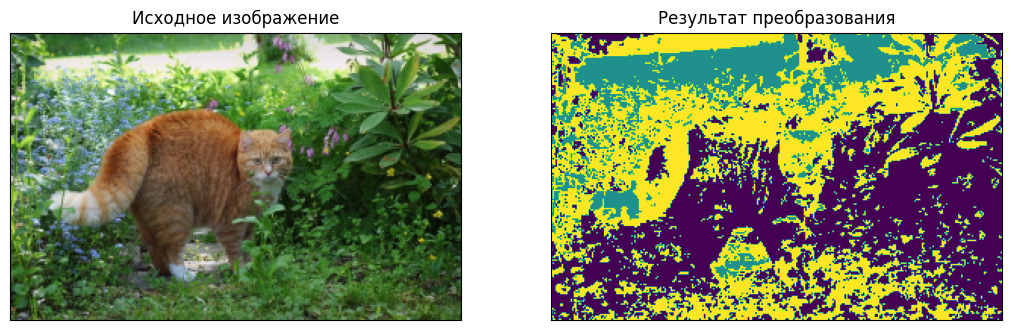

In [6]:
X = skimage.color.rgb2gray(image).reshape(-1, 1)
# plot_one_image(image)
n_clusters = 3  # number of regions
kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters)
kmeans.fit(X)
label_knn = np.reshape(kmeans.labels_, image.shape[:2])
plot_transform_result(image, label_knn[...])

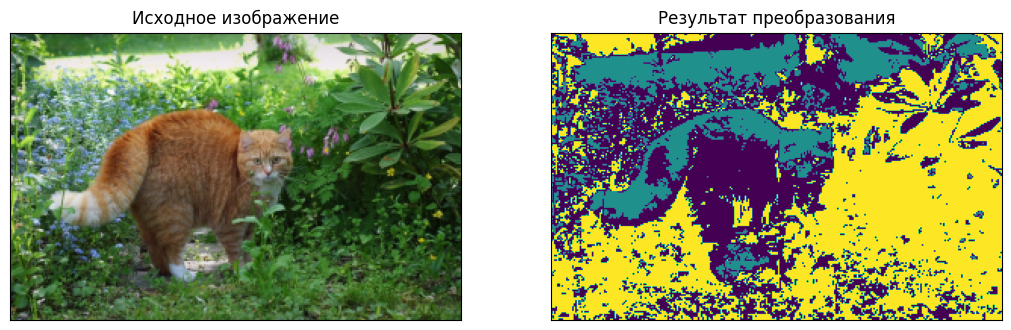

In [7]:
X = image[..., 0].reshape(-1, 1)
# plot_one_image(image)
n_clusters = 3  # number of regions
kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters)
kmeans.fit(X)
label_knn = np.reshape(kmeans.labels_, image.shape[:2])
plot_transform_result(image, label_knn[...])

## Разница в представлении кодировки цвета

In [8]:
image_ = skimage.color.rgb2hsv(image)
X = np.reshape(image_[:, :, 0], (-1, 1))

In [9]:
n_clusters = 3 # number of regions
kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, init='k-means++', 
                                n_init=40, algorithm='elkan',
                                max_iter=1000).fit(X)
label_knn_hsv = np.reshape(kmeans.labels_, image[:, :, 0].shape)

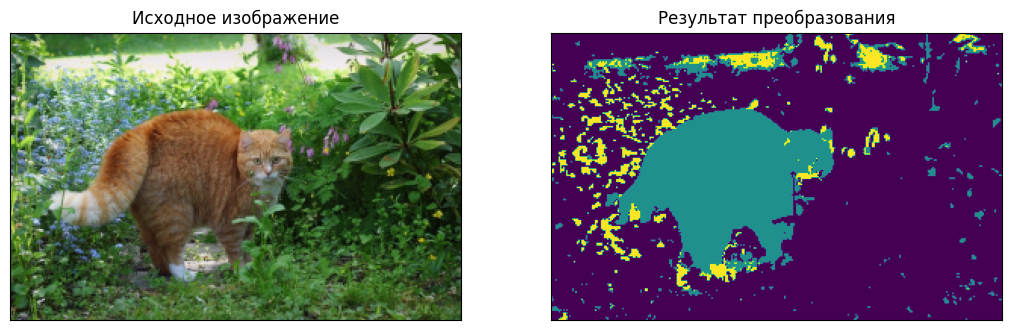

In [10]:
plot_transform_result(image, label_knn_hsv[...])

# Agglomerative clustering

[link video](https://youtu.be/2IVAznQwdS4), [link docs](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html), [link github](https://github.com/alianoroozi/Image-Clustering/blob/master/Image_clustering_agglomerative_from_scratch.ipynb)

In [11]:
# Generate data
image = skimage.io.imread('img/cat.jpg')
image = skimage.transform.resize(image, tuple(map(int, np.array(image.shape[:2])/2)))
X = np.reshape(image, (-1, 1))

## Algo

In [12]:
# Define the structure A of the data. Pixels connected to their neighbors.
connectivity = grid_to_graph(*image.shape)

# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=3, connectivity=connectivity,
        linkage='ward', distance_threshold=None).fit(X)

label_aggl = np.reshape(ward.labels_, image.shape)
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", label_aggl.size)
print("Number of clusters: ", np.unique(label_aggl).size)

Compute structured hierarchical clustering...
Elapsed time:  12.066234350204468
Number of pixels:  169860
Number of clusters:  3


### Plot clustering result

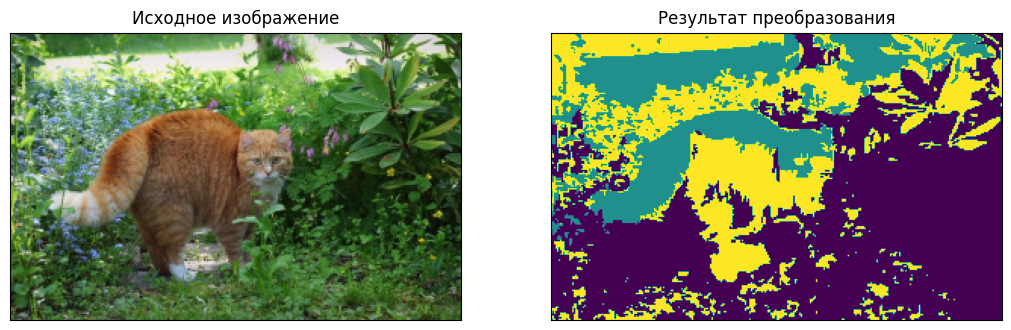

In [13]:
plot_transform_result(image, label_aggl[..., 0])

# Mean-shift clustering

[link video](https://www.youtube.com/watch?v=PCNz_zttmtA), [link docs](https://scikit-image.org/docs/stable/api/skimage.segmentation.html)

![](img/mean_shift.png)

![](img/mean_shift2.png)


In [14]:
# Generate data
image = skimage.io.imread('img/cat.jpg')
image = skimage.transform.resize(image, tuple(map(int, np.array(image.shape[:2])/2)))

## Mean-shift

In [15]:
%%time
image_ = skimage.color.rgb2hsv(image)

label_mean_sh = skimage.segmentation.quickshift(image_, kernel_size=10, max_dist=6,
                                                 ratio=0.8,
                                                 convert2lab=True)

CPU times: total: 1.64 s
Wall time: 1.65 s


In [16]:
n_clusters = np.unique(label_mean_sh).max()
print(n_clusters)

8694


### Plot clustering result

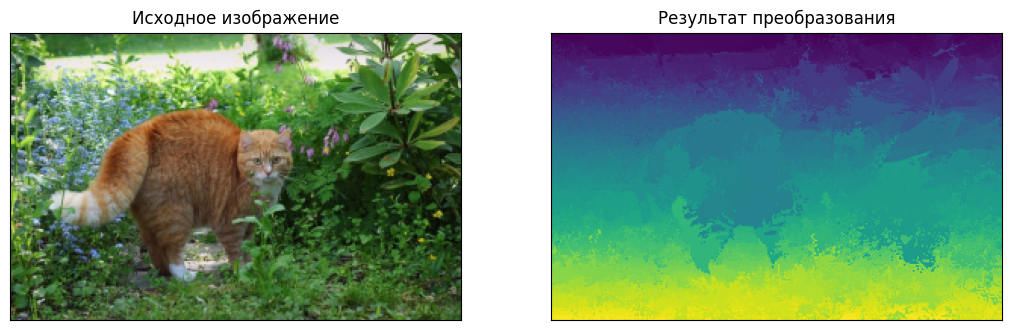

In [17]:
plot_transform_result(image, label_mean_sh)

# Felzenszwalb algo

Felzenszwalb's algorithm takes a graph-based approach to segmentation. It first constructs an undirected graph with the image pixels as vertices (the set to be segmented) and the weight of an edge between the two vertices being some measure of the dissimilarity (for example, the difference in intensity). In the graph-based approach, the problem of partitioning an image into segments translates to finding a connected components in the constructed graph. The edges between two vertices in the same component should have relatively low weights, and edges between vertices in different components should have higher weights.

In [18]:
label_felz = skimage.segmentation.felzenszwalb(image, scale=100, sigma=0.5, min_size=50)

In [19]:
n_clusters = np.unique(label_felz).max()
print(n_clusters)

224


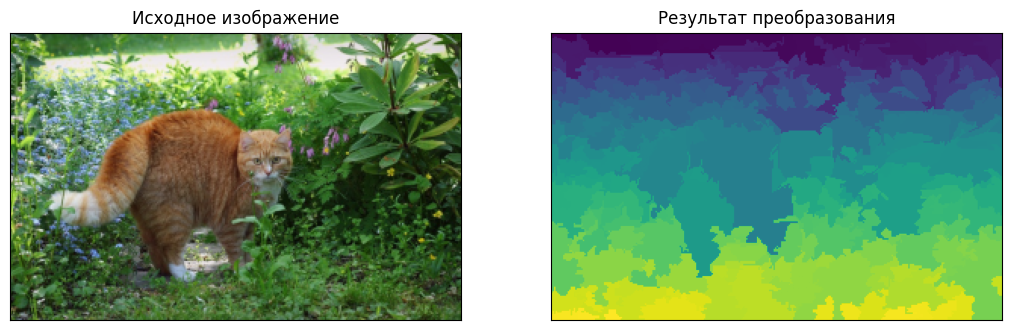

In [20]:
plot_transform_result(image, label_felz)

# Метрики для сегментации задачи

Есть 2 способа кодировать предсказания в масках.

1. Предсказание для каждого класса записывать в отдельный канал предсказания. Если классов С, а размер исходного изображения H, W, то предсказание будет размера (H, W, C), где каждый канал (бинарный) означает результат классификации для каждого класса С.

2. Предсказание для каждого класса записывается в виде целого числа в один канал. Если классов С, а размер исходного изображения H, W, то предсказание будет размера (H, W), где значения предсказаний лежат в диапазоне [0, C].

Дальше мы будем придерживаться первого способа кодирования результата сегментации.

In [21]:
# смоделируем пример маски сегментации после алгоритма

true_mask = np.zeros((400, 400, 3))  # истинная маска
true_mask[50:100, 30:370] = 1

pred_mask = np.zeros((400, 400, 3))  # предсказанная маска 
pred_mask[20:60, :] = 1

Text(0.5, 1.0, 'Наше предсказание')

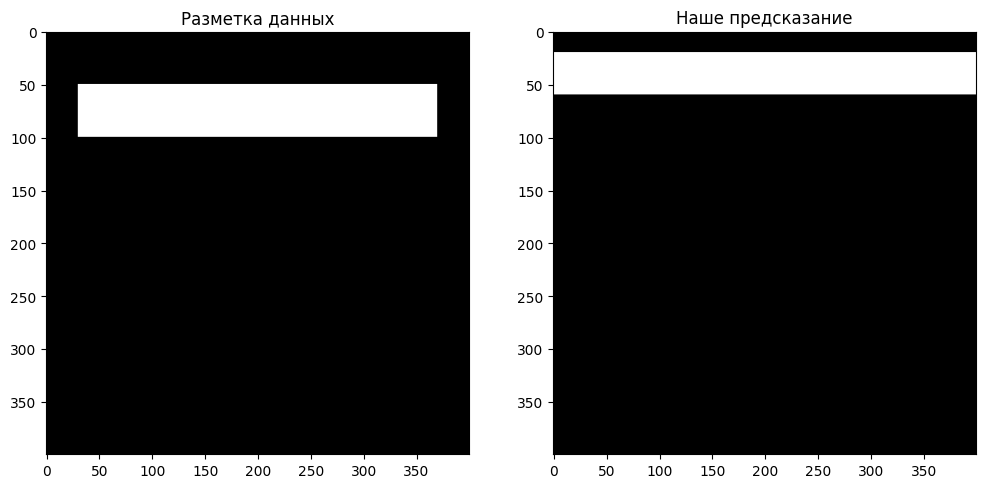

In [22]:
# отобразим
# plot_transform_result(true_mask, pred_mask)
fg, ax = plt.subplots(1, 2, figsize=(12, 10))
ax[0].imshow(true_mask)
ax[0].set_title('Разметка данных')
ax[1].imshow(pred_mask)
ax[1].set_title('Наше предсказание')

## Dice метрика

<table><tr>
    <td> <img src="img/dice.png" alt="Drawing" style="width: 300px;"/> </td>
</tr></table>

In [23]:
def dice_channel(probability, truth, threshold):
    # 
    print(f'shape of prob is {probability.shape}, shape of gtruth is {truth.shape}')
    batch_size = truth.shape[0]
    channel_num = truth.shape[3]
    mean_dice_channel = 0.
    all_channels = []
    print(f'channel num is {channel_num}, batch size is {batch_size}')
    for i in range(batch_size):
        for j in range(channel_num):
            channel_dice = dice_single_channel(probability[i, :, :, j], truth[i, :, :, j], threshold)
            all_channels.append(channel_dice)
            mean_dice_channel += channel_dice/(batch_size * channel_num)
    return mean_dice_channel, all_channels


def dice_single_channel(probability, truth, threshold, eps=1E-9):
    # 
    t = (truth.flatten() > 0.5)
    p = (probability.flatten() > threshold)
    dice = (2.0 * (p * t).sum() + eps) / (p.sum() + t.sum() + eps)
    return dice

In [24]:
mean_dice, all_dice = dice_channel(np.array([pred_mask]), np.array([true_mask]), 0.5)

print('Mean Dice:', f'{mean_dice: .3f}')
print('Dice per channel:', all_dice)

shape of prob is (1, 400, 400, 3), shape of gtruth is (1, 400, 400, 3)
channel num is 3, batch size is 1
Mean Dice:  0.206
Dice per channel: [0.20606060606063015, 0.20606060606063015, 0.20606060606063015]


## Jaccard score (IoU)

<table><tr>
    <td> <img src="img/iou.png" alt="Drawing" style="width: 300px;"/> </td>
</tr></table>

In [25]:
def jaccard_score(preds, labels, C, EMPTY=1., ignore=None, per_image=False):
    """
    Array of IoU for each (non ignored) class
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        iou = []
        for i in range(C):
            if i != ignore: # The ignored label is sometimes among predicted classes (ENet - CityScapes)
                intersection = ((label == i) & (pred == i)).sum()
                union = ((label == i) | ((pred == i) & (label != ignore))).sum()
                if not union:
                    iou.append(EMPTY)
                else:
                    iou.append(float(intersection) / union)
                
        ious.append(iou)
    ious = map(np.mean, zip(*ious)) # mean accross images if per_image
    return np.array(tuple(ious))

In [26]:
iou = jaccard_score(np.array([pred_mask]), np.array([true_mask]), C=2, EMPTY=0, per_image=False)

print('Mean IoU:', iou)
# print('Dice per channel:', all_dice)

Mean IoU: [0.83269476 0.11486486]


# Naive Bayes Classifier

Воспользуемся моделью наивного байесовского классификатора для сегментации - воспользуемся постановкой задачи, что требуется классифицировать каждый пиксель.

<table><tr>
    <td> <img src="img/bayes.png" alt="Drawing" style="width: 800px;"/> </td>
</tr></table>

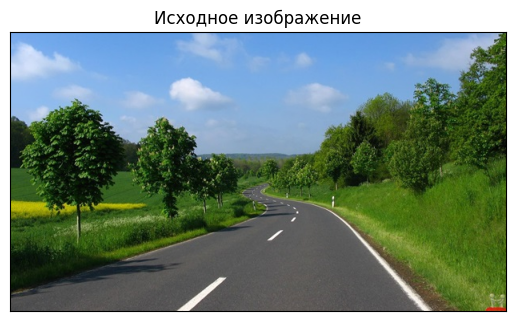

In [27]:
path = "img/test2-mini.jpg"
arr = skimage.io.imread(path)

plot_one_image(arr)

## Формируем обучающую выборку

In [28]:
# априорная информация
paths = ["img/Sky.jpg", "img/Road.jpg", "img/Grass.jpg"]
initial_probability = {"img/Sky.jpg": 0.30, "img/Road.jpg": 0.20, "img/Grass.jpg": 0.50}

# сохраняем результаты расчета априорной информации
number_of_pixels = arr.size
class_info = []

for path in paths:
    tmp_arr = skimage.io.imread(path)
 
    # расчет распределения признака № 1 (значения пикселя - RGB)
    class_mean = np.array([np.mean(tmp_arr[..., i]) for i in range(3)])
    class_var = np.array([np.var(tmp_arr[..., i]) for i in range(3)])
       
    class_info.append([initial_probability[path], class_mean, class_var])

print("class_info")
print(class_info)

class_info
[[0.3, array([130.28969924, 174.0739676 , 226.18619817]), array([689.13679397, 210.01716557,  84.62456169])], [0.2, array([95.86226841, 95.07510164, 93.95037886]), array([1030.41717571,  954.10396864,  871.11073886])], [0.5, array([48.32293121, 73.43406051, 21.27328704]), array([1123.35863883, 1445.09504227,  428.56042123])]]


## Строим модель

In [29]:
# многомерное распеределение Гаусса
from scipy.stats import multivariate_normal
from tqdm import trange

In [30]:
def naive_bayes_predict (arr, class_info, fixed_pixels_index=[], correct_arr = []):
    predict_array = np.zeros((len(arr), len(arr[0])), dtype=float)
    
    class_color = [0, 127, 255]  # цвет класса для отображения
    
    # попиксельная классификация
    for i in trange(0, len(arr)):
        for j in range(0, len(arr[0])): 
            if (len(fixed_pixels_index) > 0 and len(correct_arr) > 0 and fixed_pixels_index[i][j] == 1):
                predict_array[i][j] = correct_arr[i][j]
                continue
                
            max_probabilty = 0
            best_class = -1
            val = arr[i][j]  # текущее значение пикселя
            
            # проверить вероятность для каждого класса и выбрать наиболее вероятнный
            for cls_index in range(len(class_info)):
                cls_p = class_info[cls_index][0]  # априорная вероятность
                mean = class_info[cls_index][1]  # среднее признака 
                var = class_info[cls_index][2]  # вариация признака


                pos = multivariate_normal.pdf(val, mean, var)  # вероятность 
                cls_posterior = cls_p * pos

                if (cls_posterior > max_probabilty):
                    max_probabilty = cls_posterior
                    best_class = cls_index
            
            predict_array[i][j] = class_color[best_class]
            
    return predict_array

In [31]:
# расчет
initial_arr = naive_bayes_predict(arr, class_info)

100%|██████████| 349/349 [00:38<00:00,  9.10it/s]


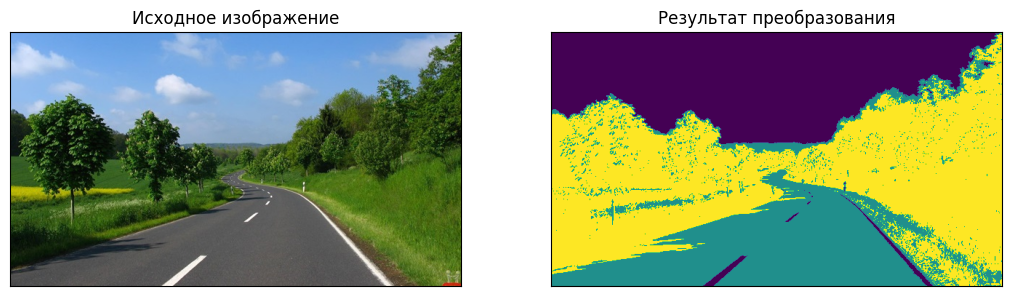

In [32]:
plot_transform_result(arr, initial_arr)

# MRF

<table><tr>
    <td> <img src="img/mrf.png" alt="Drawing" style="width: 800px;"/> </td>
</tr></table>

In [33]:
import random
import os

In [34]:
def differnce(a, b):
    if a == b:
        return -1
    else:
        return 1

In [35]:
def exponential_schedule(current_t,  constant=0.99):
    return current_t*constant


def pdf_of_normal(x, mean, var):  # prob dens fun
    try:
        k=(1/np.sqrt(2 *  np.pi * var))*np.exp(-((x-mean)**2)/(2*var))
    except:
        k=0
    if k < 1e-20:
        k=0
    return k

In [36]:
def convert_to_class_labels(arr, class_color):
    inverse_array = {class_color[i]:i for i in range(0, len(class_color))}
    for i in range(0, len(arr)):
        for j in range(0, len(arr[0])):
            arr[i][j] = inverse_array[int(arr[i][j])]

In [37]:
def delta_enegry(w, index, betha, new_value, neighbors_indices, pixels, cls_info):
    initial_energy = 0
    (i, j) = index
    rows = len(w)
    cols = len(w[0])
    mean = cls_info[int(w[i][j])][1]
    var = cls_info[int(w[i][j])][2]
    initial_energy += np.log(np.sqrt(2 * np.pi * var))
    initial_energy += ((pixels[i][j] - mean) ** 2) / (2 * var)
    for a, b in neighbors_indices:
        a += i
        b += j
        if 0 <= a < rows and 0 <= b < cols:
            initial_energy += betha * differnce(w[i][j], w[a][b])

    new_energy = 0
    mean = cls_info[new_value][1]
    var = cls_info[new_value][2]
    new_energy += np.log(np.sqrt(2 * np.pi * var))
    new_energy += ((pixels[i][j] - mean) ** 2) / (2 * var)

    for a, b in neighbors_indices:
        a += i
        b += j
        if 0 <= a < rows and 0 <= b < cols:
            new_energy += betha * differnce(new_value, w[a][b])

    return new_energy - initial_energy

In [38]:
def initial_energy_function(initial_w, pixels, betha, cls_info, neighbors_indices):
    w = initial_w
    energy = 0.0
    rows = len(w)
    cols = len(w[0])
    for i in range(0, len(w)):
        for j in range(0, len(w[0])):
            mean = cls_info[int(w[i][j])][1]
            var = cls_info[int(w[i][j])][2]
            energy += np.log(np.sqrt(2 * np.pi * var))
            energy += ((pixels[i][j] - mean) ** 2) / (2 * var)
            for a, b in neighbors_indices:
                a += i
                b += j
                if 0 <= a < rows and 0 <= b < cols:
                    energy += betha * differnce(w[i][j], w[a][b])

    print('energy=', energy)
    return energy


In [39]:
def create_classes(paths):
    class_info = []
    for path in paths:
        tmp_arr = cv2.imread(path)
        tmp_arr = cv2.cvtColor(tmp_arr,cv2.COLOR_RGB2GRAY)

        class_mean = np.mean(tmp_arr)
        class_var = np.var(tmp_arr)
        class_info.append([1, class_mean, class_var])
    print ("class_info")
    print (class_info)
    return class_info

In [40]:
import warnings
def simulated_annealing(init_w, class_labels, temprature_function,
                        pixels, betha, cls_info, neighbors_indices, max_iteration=10000,
                        initial_temp=1000):
    w = np.array(init_w)
    changed_array = np.zeros((len(w), len(w[0])))
    x = len(w)
    y = len(w[0])
    current_energy = initial_energy_function(w, pixels, betha, cls_info, neighbors_indices)
    current_tmp = initial_temp
    for itr in trange(int(max_iteration)):

        i = random.randint(0, x - 1)
        j = random.randint(0, y - 1)

        l = list(class_labels)
        l.remove(w[i][j])
        r = random.randint(0, len(l) - 1)
        new_value = l[r]
        delta = delta_enegry(w, (i, j), betha, new_value, neighbors_indices, pixels, cls_info)

        r = random.uniform(0, 1)

        if (delta <= 0):
            w[i][j] = new_value
            current_energy += delta
            changed_array[i][j] += 1
        else:
            if (-delta / current_tmp < -600):
                k = 0
            else:
                k = np.exp(-delta / current_tmp)

            if r < k:
                w[i][j] = new_value
                current_energy += delta
                changed_array[i][j] += 1

        current_tmp = temprature_function(current_tmp)
       
    return w, changed_array


def mrf_grayscale(img_path, parts_paths, max_iter=1000000, var=10000,
                  betha=100,
                  neighbor_indices=[[0, 1], [0, -1], [1, 0], [-1, 0]],
                  schedule=exponential_schedule, save_bayes_path=None):
    class_labels = [i for i in range(0, len(parts_paths))]
    class_color = [int(i * (255 / (len(class_labels) - 1))) for i in class_labels]

    arr = cv2.imread(img_path)
    arr = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 32))
    ax1.set_title("initial image")
    ax1.imshow(arr, cmap='gray')

    cls_info = create_classes(parts_paths)
    if os.path.isfile(save_bayes_path):
        initial_arr = np.load(save_bayes_path)
    else:
        initial_arr = naive_bayes_predict(arr, cls_info, class_color)
        if save_bayes_path:
            np.save(save_bayes_path, initial_arr)

    ax2.set_title('Naive Bayes image')
    ax2.imshow(initial_arr)

    convert_to_class_labels(initial_arr, class_color)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        w, test_array = simulated_annealing(initial_arr, class_labels, schedule,
                                            arr, betha, cls_info, neighbor_indices, max_iteration=max_iter)

    for i in range(0, len(w)):
        for j in range(0, len(w[0])):
            w[i][j] = class_color[int(w[i][j])]

    ax3.set_title('MRF image')
    ax3.imshow(w)

    ax4.set_title('differ image')

    ax4.imshow((test_array / test_array.max()))
    print(np.max(test_array), np.min(test_array))
    plt.show()
    
    return w, initial_arr


class_info
[[1, 184.7031425317417, 156.9684285603993], [1, 54.98855823410818, 917.6273913578044], [1, 94.91060166789873, 934.0133966602652]]
energy= 244151.4956705235


100%|██████████| 1000000/1000000 [00:11<00:00, 85871.24it/s]

3.0 0.0


<Figure size 1280x1440 with 0 Axes>

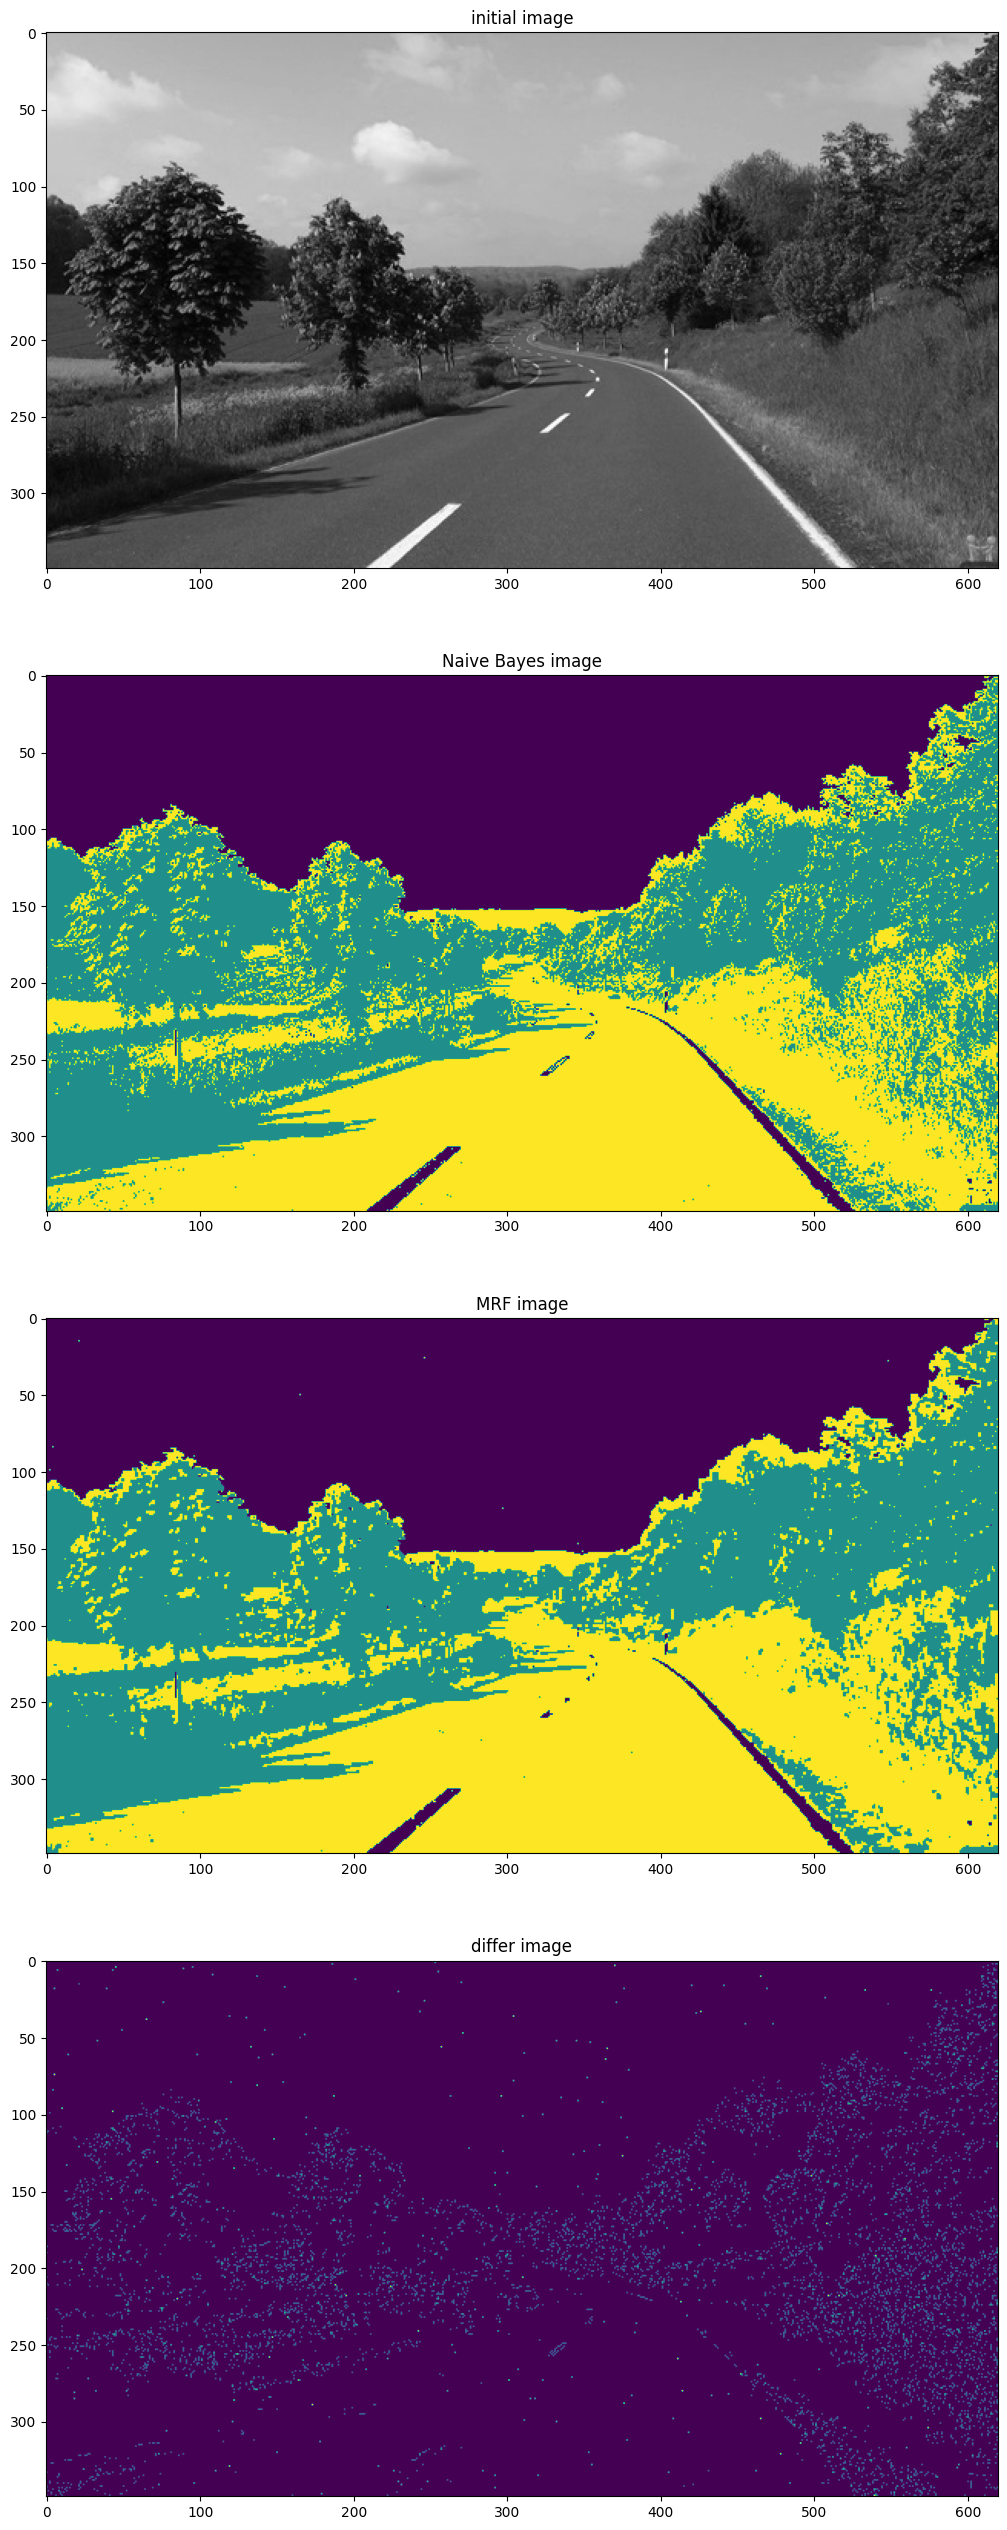

In [46]:
plt.figure(figsize=(16, 18), dpi=80, facecolor='w', edgecolor='k')

img_path = "img/test2-mini.jpg"
parts_paths=["img/sky.jpg","img/grass.jpg","img/road.jpg"]
save_bayes_path = "bayes.npy"

train_segm_clr, train_segm_cls = mrf_grayscale(img_path, parts_paths, max_iter=1e6, betha=1, save_bayes_path = save_bayes_path)

## NB 3D

In [42]:
from scipy.stats import multivariate_normal

def naive_bayes_predict_multivariate(arr, class_info):
    num_of_layers = len(class_info)
    probs = np.zeros([num_of_layers, *arr.shape[:2]], dtype=float)

    for i, (cls_prob, cls_mean, cls_std) in enumerate(class_info):
        pdf_cls = multivariate_normal.pdf(arr, mean=cls_mean, cov=cls_std)
        probs[i] = pdf_cls * cls_prob

    # карта классов, значение пикселя = номер класса
    predict = np.argmax(probs, axis=0)
    nb_predict = predict.copy()

    max_probs = np.max(probs, axis=0)
    max_probs = np.where(max_probs < 1e-10, 1, 0)

    predict[max_probs == 1] = num_of_layers

    return probs, nb_predict, predict


In [43]:
# априорная информация
paths = ["img/Sky.jpg", "img/Road.jpg", "img/Grass.jpg"]
initial_probability = {"img/Sky.jpg": 0.30, "img/Road.jpg": 0.20, "img/Grass.jpg": 0.50}

# сохраняем результаты расчета априорной информации
number_of_pixels = arr.size
class_info = []

for path in paths:
    tmp_arr = skimage.io.imread(path).reshape(-1, 3)
    # расчет распределения признака № 1 (значения пикселя - RGB)
    class_mean = np.mean(tmp_arr, axis=0)
    class_var = np.cov(tmp_arr.T)

    class_info.append([initial_probability[path], class_mean, class_var])

class_info

[[0.3,
  array([130.28969924, 174.0739676 , 226.18619817]),
  array([[689.13824742, 364.97342543,  32.53360553],
         [364.97342543, 210.01760851,  51.47964383],
         [ 32.53360553,  51.47964383,  84.62474017]])],
 [0.2,
  array([95.86226841, 95.07510164, 93.95037886]),
  array([[1030.42015119,  987.82541914,  938.92578528],
         [ 987.82541914,  954.10672375,  906.04296684],
         [ 938.92578528,  906.04296684,  871.11325432]])],
 [0.5,
  array([48.32293121, 73.43406051, 21.27328704]),
  array([[1123.36025194, 1218.03318232,  454.4143396 ],
         [1218.03318232, 1445.09711738,  490.57721744],
         [ 454.4143396 ,  490.57721744,  428.56103663]])]]

In [44]:
_, initial_arr_3d, _ = naive_bayes_predict_multivariate(arr, class_info)

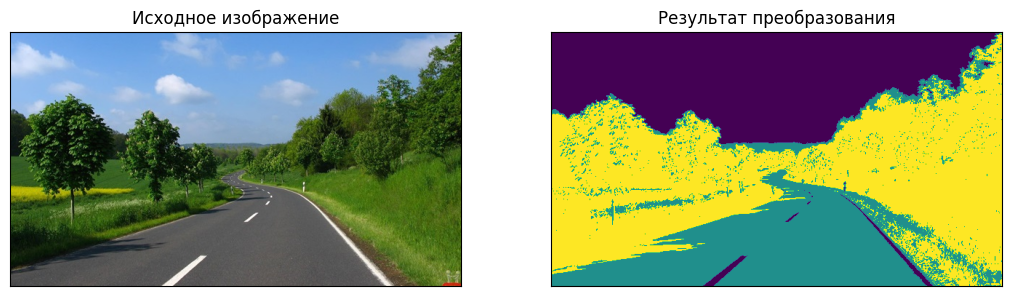

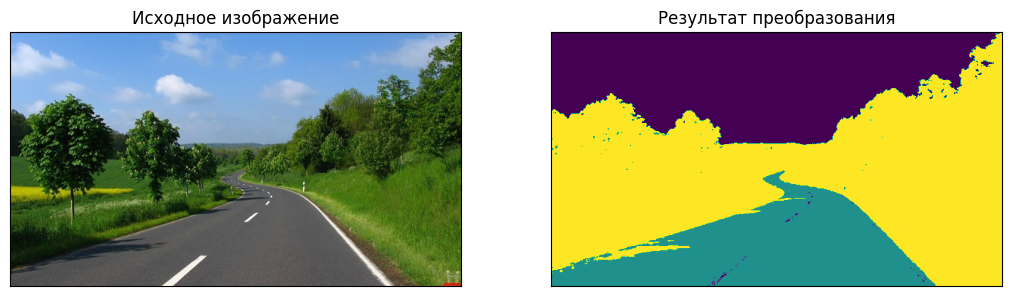

In [45]:
plot_transform_result(arr, initial_arr)
plot_transform_result(arr, initial_arr_3d)